In [1]:
import torch as pt
from torch import nn
import torch.nn.functional as F

from pyconll import iter_from_file

from tokenizer import train_mopiece, MOPiece

import regex as re

from word_autoencoder import WordEncoder
from dependency_parser import DependencyParser

from tqdm.notebook import trange, tqdm

device = ('cuda' if pt.cuda.is_available() else 'mps' if pt.backends.mps.is_available() else 'cpu')

In [2]:
# import regex as re
# reg = re.compile(r'[^\p{L}\p{M}\p{N}\s]+|\s')
# bad = 0
# total = 0
# for tree in iter_from_file('data/treebank/en_ewt-ud-train.conllu'):
#     reg_words = []
#     for word in reg.split(tree.text):
#         if word == '' or word == ' ':
#             continue
#         reg_words.append(word)
#     tree_words = []
#     beb = []
#     for word in tree:
#         if word._form is not None and word.head is not None:
#             word_s = reg.sub('', word._form)
#             if word_s:
#                 tree_words.append(word_s)
#         beb.append((word._form, word.id, word.head))
#     total += 1
#     if reg_words != tree_words and len(reg_words) == len(tree_words):
#         p = False
#         for r, t in zip(reg_words, tree_words):
#             if r != t and r[-1] != 'n' and t != 'nt':
#                 p = True
#         if p:
#             continue
#         print(tree.text)
#         print(reg_words)
#         print(tree_words)
#         print(beb)
#         print()
#         bad += 1
# print(bad, total)

In [3]:
def use_tree(tree, reg):
    reg_words = [word for word in reg.split(tree.text) if word != ' ' and word != '']
    tree_words = []
    for word in tree:
        if word._form is not None and word.head is not None:
            word_s = reg.sub('', word._form)
            if word_s:
                tree_words.append(word_s)
    if reg_words == tree_words:
        return True
    if len(reg_words) == len(tree_words):
        nts_match = True
        for r, t in zip(reg_words, tree_words):
            if r != t and r[-1] != 'n' and t != 'nt':
                nts_match = False
                break
        return nts_match
    
    
def train_tree_tokenizer(directory_path, filepath, prefixes, suffixes, spm_vocab_size: int, spm_model_type: str='bpe', min_stem: int=3):
    words = []
    reg = re.compile(r'[^\p{L}\p{M}\p{N}\s]+|\s')
    for tree in iter_from_file(filepath):
        if use_tree(tree, reg):
            for word in tree:
                if word._form is not None and word.head is not None:
                    word_s = reg.sub('', word._form)
                    if word_s:
                        words.append(word_s)
    train_mopiece(directory_path, words, prefixes, suffixes, spm_vocab_size, spm_model_type, min_stem, False)


class TreeDataset(pt.utils.data.Dataset):
    def __init__(self, filepath, mopiece):
        reg = re.compile(r'[^\p{L}\p{M}\p{N}\s]+|\s')
        self.labels = []
        self.prefix_ids = []
        self.spm_ids = []
        self.suffix_ids = []
        bos_id = mopiece.bos_id()
        eos_id = mopiece.eos_id()
        for tree in iter_from_file(filepath):
            if use_tree(tree, reg):
                labels = []
                prefix_ids = []
                spm_ids = []
                suffix_ids = []
                skipped_ids = []
                for word in tree:
                    if word._form is not None and word.head is not None:
                        word_s = reg.sub('', word._form)
                        if word_s:
                            word_prefix_ids, word_spm_ids, word_suffix_ids = mopiece.encode_word(word_s)
                            prefix_ids.append([bos_id] + word_prefix_ids + [eos_id])
                            spm_ids.append([bos_id] + word_spm_ids + [eos_id])
                            suffix_ids.append([bos_id] + word_suffix_ids + [eos_id])
                            labels.append(int(word.head))
                            continue
                    if '-' not in word.id and '.' not in word.id:
                        skipped_ids.append(int(word.id))
                self.prefix_ids.append(prefix_ids)
                self.spm_ids.append(spm_ids)
                self.suffix_ids.append(suffix_ids)
                for i, label in enumerate(labels):
                    labels[i] -= sum([label >= j for j in skipped_ids])
                self.labels.append(pt.tensor(labels, dtype=pt.long))
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.prefix_ids[index], self.spm_ids[index], self.suffix_ids[index], self.labels[index]

In [ ]:
with open(r'data\morphynet\prefixes.csv') as file:
    prefixes = [s[:-1] for s in file.readlines()[1:]]
with open(r'data\morphynet\suffixes.csv') as file:
    suffixes = [s[:-1] for s in file.readlines()[1:]]
train_tree_tokenizer('____tree_tokenizer', 'data/treebank/en_ewt-ud-train.conllu', prefixes, suffixes, 3000)

In [4]:
mopiece = MOPiece('____tree_tokenizer')
train_dset = TreeDataset(r'data\treebank\en_ewt-ud-train.conllu', mopiece)
test_dset = TreeDataset(r'data\treebank\en_ewt-ud-test.conllu', mopiece)

In [5]:
pad_id = mopiece.pad_id()

def collate_fn(batch):
    def handle_component(i):
        max_len = max_sublen = 0
        for tup in batch:
            seq = tup[i]
            max_len = max(max_len, len(seq))
            for subseq in seq:
                max_sublen = max(max_sublen, len(subseq))
        tensor = []
        for tup in batch:
            seq = tup[i]
            tensor_seq = []
            for subseq in seq:
                tensor_seq.append(subseq + [pad_id] * (max_sublen - len(subseq)))
            for _ in range(max_len - len(seq)):
                tensor_seq.append([pad_id] * max_sublen)
            tensor.append(tensor_seq)
        return pt.tensor(tensor, dtype=pt.long)

    return handle_component(0), handle_component(1), handle_component(2), nn.utils.rnn.pad_sequence([labels for prefix, spm, suffix, labels in batch], batch_first=True, padding_value=-1)

In [6]:
train_loader = pt.utils.data.DataLoader(train_dset, batch_size=8, shuffle=True, collate_fn=collate_fn, pin_memory=True, drop_last=True)
test_loader = pt.utils.data.DataLoader(test_dset, batch_size=8, collate_fn=collate_fn, pin_memory=True, drop_last=True)

criterion = nn.CrossEntropyLoss(ignore_index=-1, label_smoothing=.1)

encoder = WordEncoder(mopiece.vocab_size(), mopiece.pad_id(), 256, ffn_hidden_dim=512, expansion_factor=4, spm_layers=6, suffix_depth=4, prefix_depth=4).to(device)
parser = DependencyParser(256, dropout=.1).to(device)

epochs = 30
accumulate_grad = 2

optim = pt.optim.AdamW([
    {"params": encoder.parameters()},
    {"params": parser.parameters()}
], weight_decay=0.01, lr=3e-4)
lr_scheduler = pt.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

encoder.train()
parser.train()

train_losses = []
test_losses = []
test_accuracies = []
for epoch in (pbar := trange(epochs, desc='Epoch')):
    train_loss_sum = 0
    optim.zero_grad()
    for i, (prefix_ids, spm_ids, suffix_ids, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
        prefix_ids = prefix_ids.to(device)
        spm_ids = spm_ids.to(device)
        suffix_ids = suffix_ids.to(device)
        labels = labels.to(device)
        
        embeddings = encoder(prefix_ids, spm_ids, suffix_ids)
        logits = parser(embeddings, labels != -1)

        loss = criterion(logits.flatten(end_dim=-2), labels.flatten())
        loss.backward()

        if (i + 1) % accumulate_grad == 0:
            optim.step()
            optim.zero_grad()

        train_loss_sum += loss.item()

    train_loss = train_loss_sum / len(train_loader)
    train_losses.append(train_loss)
    with pt.no_grad():
        test_loss_sum = 0.
        hits = 0
        total = 0
        for prefix_ids, spm_ids, suffix_ids, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            prefix_ids = prefix_ids.to(device)
            spm_ids = spm_ids.to(device)
            suffix_ids = suffix_ids.to(device)
            labels = labels.to(device)
            
            embeddings = encoder(prefix_ids, spm_ids, suffix_ids)
            logits = parser(embeddings, labels != -1).flatten(end_dim=-2)

            logits = logits.flatten(end_dim=-2)
            labels = labels.flatten()

            test_loss_sum += criterion(logits, labels).item()
            hits += pt.sum(logits.argmax(-1) == labels).item()
            total += pt.sum(labels != -1).item()

    test_loss = test_loss_sum / len(test_loader)
    test_losses.append(test_loss)
    test_acc = hits / total
    test_accuracies.append(test_acc)
    pbar.set_postfix_str(f'train loss: {train_loss:.2f}, test loss: {test_loss:.2f}, test accuracy: {test_acc*100:.2f}%')

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

In [9]:
pt.save(encoder.state_dict(), '____tree_encoder.pt')
pt.save(parser.state_dict(), '____tree_parser.pt')

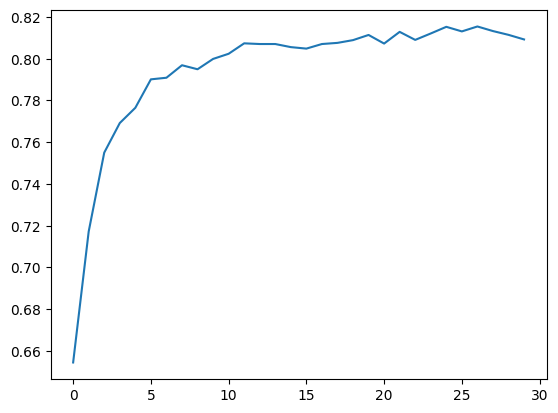

In [7]:
import matplotlib.pyplot as plt

plt.plot(test_accuracies)